# Rosembrock Target Practice

## MCHMC

In [1]:
] activate "../"

  Activating project at `~/PhD/MicroCanonicalHMC.jl/examples`


In [2]:
using Distributions
using ForwardDiff
using LinearAlgebra
using Random
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [3]:
target = RosenbrockTarget(1.0, 10.0; d=2);

In [4]:
X = LinRange(-3, 5, 100)
Y = LinRange(-2, 18, 100)
Z = zeros(length(X), length(Y))
for i in 1:length(X)
    for j in 1:length(Y)
        x = X[i]
        y = Y[j]
        Z[i, j] = exp(target.h.ℓπ([x; y]))
    end
end

In [5]:
d2_truth = vec(normalize(sum(Z, dims=1)))
d1_truth = vec(normalize(sum(Z, dims=2)))

100-element Vector{Float64}:
 7.162829369412773e-5
 9.863809139860455e-5
 0.00013494872801976375
 0.0001834243594214731
 0.0002476904756917828
 0.000332296436430068
 0.000442900469948504
 0.0005864765865858889
 0.0007715415106920719
 0.0010083980468276281
 0.001309389262123287
 0.001689155512694095
 0.0021648837232836893
 ⋮
 0.0016890587797713194
 0.001251217459171278
 0.00031134149060358854
 2.3604574783005898e-6
 1.5088638240128408e-10
 4.865587974811031e-17
 5.648489440875084e-26
 1.7465706115620848e-37
 1.0692541153538504e-51
 9.6070764266984e-69
 9.347706927905418e-89
 7.231720986524703e-112

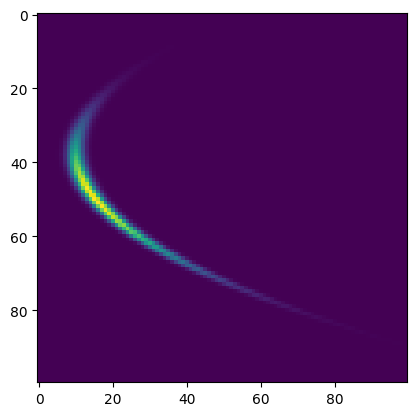

PyObject <matplotlib.image.AxesImage object at 0x7fca84536040>

In [6]:
plt.imshow(Z)

In [7]:
d = 2
spl = MCHMC(10_000, 0.01; L=sqrt(2), sigma=ones(target.d), adaptive=true)

MicroCanonicalHMC.MCHMCSampler(Settings{Float64}(10000, 0.01, 1, true, "LF", nothing, nothing, nothing), MicroCanonicalHMC.Hyperparameters{Float64}(0.0, 1.4142135623730951, 0.0, 0.1931833275037836, [1.0, 1.0], 0.9607843137254902, 1.5), MicroCanonicalHMC.Leapfrog)

In [8]:
samples_mchmc = Sample(spl, target, 500_000; dialog=true);

[ Info: sampling from prior
[ Info: Tuning eps ⏳
MCHMC (tuning):   0%|                                   |  ETA: 0:40:37

Burn in step: 2000
eps --->0.14884363533901432
Burn in step: 4000
eps --->0.11929505215753096
Burn in step: 6000
eps --->0.07430889554400592
Burn in step: 8000
eps --->0.08932103629454721
Burn in step: 10000
eps --->0.17996370047630136


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:01[ Info: eps: 0.17996370047630136
[ Info: L: 1.4142135623730951
[ Info: nu: 0.380674215534585
[ Info: sigma: [1.0, 1.0]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:06

In [9]:
samples_mchmc

500000-element Vector{Any}:
 [0.8495467729851647, 0.8398377629959439, 0.17996370047630136, -0.10651314127680422, -0.08106563646418086]
 [1.0272224782026966, 0.8112322169501749, 0.18118575300766745, -0.04556990938678823, -0.29793782110096984]
 [1.2075771544842797, 0.8285662250360413, 0.16980281805699296, 0.48656156193535843, -2.0040057229261357]
 [1.1141803317582624, 0.9703760643448183, 0.15591727041138861, -0.5735506499615506, -0.3737825117150268]
 [1.0132192967096882, 1.0891913184768474, 0.1569871617628539, -0.0182773419095264, -0.019667389835931595]
 [0.9833899012193901, 1.2433184611968753, 0.15777031223987104, 0.08279508246955218, -0.3817435198331093]
 [1.0939144083594896, 1.355905337633272, 0.1585482508014614, -0.08327430503074973, -0.1312232889375964]
 [1.2242908015077498, 1.4461247587234862, 0.15958303445586933, -0.04851872766671683, -0.03907296237740058]
 [1.348290742539415, 1.5465775312600705, 0.15926468734943328, 0.1594753645259335, -0.42869987327169656]
 [1.3486888928419087, 

In [10]:
d1_mchmc = [sample[1] for sample in samples_mchmc]
d2_mchmc = [sample[2] for sample in samples_mchmc];

## NUTS

In [11]:
using AdvancedHMC
using LogDensityProblems

In [12]:
# Define the target distribution using the `LogDensityProblem` interface
struct LogTargetDensity
    dim::Int
end
LogDensityProblems.logdensity(p::LogTargetDensity, θ) = target.h.ℓπ(θ) #-sum(abs2, θ) / 2  # standard multivariate normal
LogDensityProblems.dimension(p::LogTargetDensity) = p.dim
LogDensityProblems.capabilities(::Type{LogTargetDensity}) = LogDensityProblems.LogDensityOrder{0}()

In [14]:
# Choose parameter dimensionality and initial parameter value
initial_θ = target.prior_draw()
ℓπ = LogTargetDensity(target.d)

# Set the number of samples to draw and warmup iterations
n_samples, n_adapts = 100_000, 10_000

# Define a Hamiltonian system
metric = DiagEuclideanMetric(target.d)
hamiltonian = Hamiltonian(metric, ℓπ, ForwardDiff)

# Define a leapfrog solver, with initial step size chosen heuristically
initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
integrator = AdvancedHMC.Leapfrog(initial_ϵ)

# Define an HMC sampler, with the following components
#   - multinomial sampling scheme,
#   - generalised No-U-Turn criteria, and
#   - windowed adaption for step-size and diagonal mass matrix
kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.9, integrator))

# Run the sampler to draw samples from the specified Gaussian, where
#   - `samples` will store the samples
#   - `stats` will store diagnostic statistics for each sample
samples_hmc, stats = sample(hamiltonian, kernel, initial_θ, n_samples, adaptor, n_adapts; progress=true);

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/vnCY0/src/ProgressMeter.jl:626
Sampling 100%|███████████████████████████████| Time: 0:00:05
  iterations:                                   100000
  ratio_divergent_transitions:                  0.0
  ratio_divergent_transitions_during_adaption:  0.0
  n_steps:                                      3
  is_accept:                                    true
  acceptance_rate:                              1.0
  log_density:                                  -2.9689989400583356
  hamiltonian_energy:                           3.675000272733663
  hamiltonian_energy_error:                     -0.19172515227923448
  max_hamiltonian_energy_e

In [15]:
d1_hmc = [sample[1] for sample in samples_hmc]
d2_hmc = [sample[2] for sample in samples_hmc];

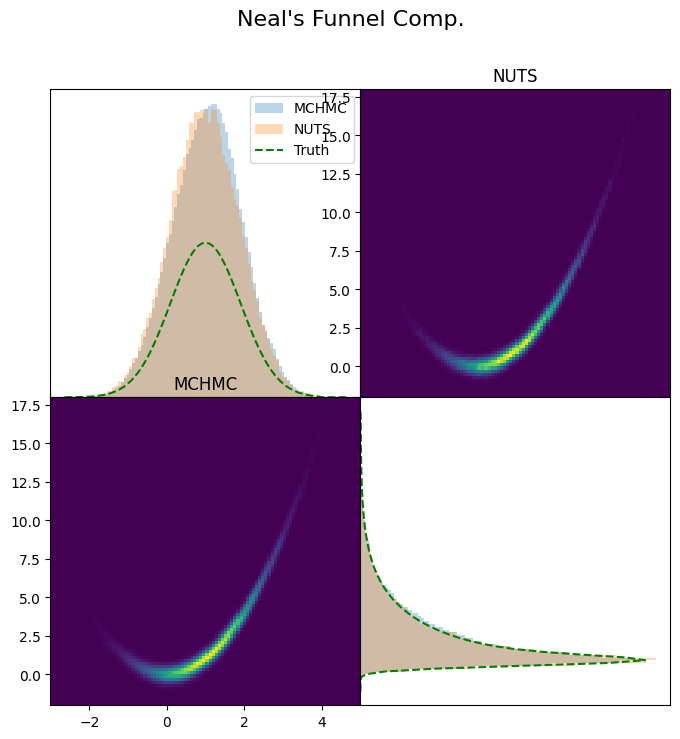

In [16]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel Comp.", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(d1_mchmc, bins=100, density=true, range=[-3,5], alpha = 0.3, label="MCHMC")
axis[1,1].hist(d1_hmc, bins=100, density=true, range=[-3,5], alpha = 0.3, label="NUTS")
axis[1,1].plot(X, d1_truth, "g--", label="Truth")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(d2_mchmc, bins=100, density=true, orientation="horizontal", range=[-2, 18], alpha = 0.3)
axis[2,2].hist(d2_hmc, bins=100, density=true, orientation="horizontal", range=[-2, 18], alpha = 0.3)
axis[2,2].plot(d2_truth, Y, "g--", label="Truth")
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(d1_hmc, d2_hmc, bins=100, range=[[-3,5],[-2, 18]])
axis[1,2].set_title("NUTS")

axis[2,1].hist2d(d1_mchmc, d2_mchmc, bins=100, range=[[-3,5],[-2, 18]])
axis[2,1].set_title("MCHMC")
;